# Data Analysis
Author: Leon Yin<br>
Date: 2020-2-03<br>

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

In [4]:
# input
fn_metadata = '../data/intermediary/element_metadata_15k.jsonl.gz'
# fn_metadata = '/mnt/n1p1/data/platforms/google/experiment/intermediary__V1/element_metadata_15k.jsonl.gz'
# output
output_dir = '../data/output'
tables_dir = os.path.join(output_dir, 'tables/')
figure_dir = os.path.join(output_dir, 'figures/')
appendix_dir = os.path.join(output_dir, 'appendix/')

for d in [tables_dir, figure_dir, appendix_dir]:
    os.makedirs(d, exist_ok=True)

In [5]:
df = pd.read_json(fn_metadata, lines=True, 
                  compression='gzip')

In [6]:
df.fn_input.nunique()

15281

In [7]:
print(json.dumps(df.sample(1).iloc[-1].to_dict(), 
                 indent=2))

{
  "text": "",
  "link": null,
  "domain": "google.com",
  "xpath": "/html/body/div[10]/div/div[6]/div/div[3]/div/div/div/sticky-header/div[2]/div/g-flippy-carousel/div/div/ol/li[1]/span/div/div/div[1]/div[3]/div[1]/div/div/div/div/div/div/div/image-viewer-group/div/div[1]/div/g-scrolling-carousel/div/div[1]/div/div[10]/div/a/g-inner-card/g-img/img",
  "category": "link-img_reverse",
  "tag": "img",
  "attrs": {
    "data-src": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTVLrgX-sC4UO0nZNp4YKMnUXUMYneIcRLEA4tVAs7hxlIxAa0qeqkcXvIyNg&s",
    "src": "data:image/gif;base64,R0lGODlhAQABAIAAAP///////yH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==",
    "jscontroller": "SvnKM",
    "jsaction": "load:K1e2pe;lzy_img:eNYuKb;pr_lzy_img:KpWyKc;rcuQ6b:npT2md",
    "class": [
      "rISBZc",
      "M4dUYb"
    ],
    "style": "margin-left:-51px;margin-right:-45px",
    "alt": "Image result for Lizzy Caplan",
    "data-atf": "4",
    "width": "288",
    "height": "144"
  },
  "dimensions": {
    "heig

In [8]:
# first glance
df.groupby('label') \
  .area.sum() \
  .sort_values(ascending=False) / df.area.sum()

label
link       0.388062
answer     0.230052
organic    0.192419
amp        0.123685
ads        0.065782
Name: area, dtype: float64

In [9]:
# full page
df.groupby('label') \
  .area_page.sum() \
  .sort_values(ascending=False)/ df.area_page.sum()

label
organic    0.438363
link       0.279153
amp        0.137285
answer     0.135438
ads        0.009762
Name: area_page, dtype: float64

## Breakdown of area and frequency for each category

In [10]:
# get area per standardized category
cat_area_ = (df.groupby('category_standard')
               .area_page.sum()
               .divide(df.area_page.sum()))

cat_area =(df.groupby('category_standard')
             .area.sum()
             .divide(df.area.sum()))

In [11]:
(df.groupby('category_standard')
             .area.sum()
             .divide(df.area.sum()))

category_standard
ads                             0.065782
amp-card                        0.117027
amp-search_result               0.003847
amp-visual_stories              0.002811
google-answer                   0.198391
google-expandable-answer        0.031661
google-images                   0.142077
google-knowledge-panel-links    0.080113
google-maps                     0.015499
google-misc                     0.097243
google-search                   0.031657
google-video                    0.021474
organic                         0.072854
organic-search_result           0.119564
Name: area, dtype: float64

In [12]:
n_pages = df[df.area != 0].fn_input.nunique()

In [13]:
# number of elements on first glance
cat_count = Counter()
for fn, _df in df[df.area != 0].groupby('fn_input'):
    cat_count.update(_df.category_standard.unique())
df_wc = pd.DataFrame(cat_count.most_common(50),
                     columns=['category_standard', 'count'])
df_wc['freq'] = df_wc['count'] / n_pages 

# number of elements on full page
cat_count_ = Counter()
for fn, _df in df[df.area_page != 0].groupby('fn_input'):
    cat_count_.update(_df.category_standard.unique())
df_wc_ = pd.DataFrame(cat_count_.most_common(50),
                     columns=['category_standard', 'count_page'])
df_wc_['freq_page'] = df_wc_['count_page'] / n_pages 

In [14]:
cat_amp = df[df.label == 'amp'].category_standard.unique()
cat_sd = df[df.label == 'link'].category_standard.unique()
cat_rt = df[df.label == 'answer'].category_standard.unique()
cat_ad = df[df.label == 'ads'].category_standard.unique()
cat_og = df[df.label == 'organic'].category_standard.unique()

In [15]:
cat_og

array(['organic-search_result', 'organic'], dtype=object)

In [16]:
def format_number(x):
    """Makes it nice for printing"""
    x = x * 100
    x = round(x, 2)
    return f"{x}%"

In [17]:
def breakdown(categories : list(), 
              col='category_standard'):
    """Shows the area coverage and page frequency for each category  """
    full_page =df_wc_[df_wc_[col].isin(categories)] \
            .join(cat_area_.to_frame(),
                  on=col,
                  how='left')

    output = (df_wc[df_wc[col].isin(categories)]
        .join(cat_area.to_frame(),
              on=col,
              how='left')
        .sort_values(by=['area'], 
                     ascending=False)
        .reset_index(drop=True)
        .merge(full_page)
    )
    
    output = output[[c for c in output.columns if 'count' not in c]]
        
    fg_area = output['area'].sum()
    fp_area = output['area_page'].sum()
    
    output = output.append(
        {'category_standard' : 'Total', 
         'freq' : np.nan, 
         'area' : fg_area, 
         'freq_page' : np.nan, 
         'area_page' : fp_area},
        ignore_index=True
    )
    return output.set_index(col)


## Breakdown of area and frequency for each category

In [18]:
columns = [
   ('Above the fold', 'area'),
   ('Above the fold' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [19]:
total_area = df['area'].sum()
total_area_fp = df['area_page'].sum()
n_pages = df.fn_input.nunique()

In [20]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

In [21]:
labels = [
    'organic',
    'amp',
    'link',
    'answer',
    'ads'
]

In [22]:
df_cat_agg = pd.DataFrame()
for categories in [cat_ad, cat_amp, cat_rt, cat_sd, cat_og]:
    output = breakdown(categories)
    df_cat_agg = df_cat_agg.append(output)
    
    output.columns = pd.MultiIndex.from_tuples([
       ('Above the fold', 'freq'),
       ('Above the fold' , 'area'),
       ('Full page', 'freq'),
       ('Full page' , 'area'),
    ])
    for c, dtype in output.dtypes.items():
        if pd.api.types.is_numeric_dtype(output[c]):
            output[c] = output[c].apply(format_number)
    
    display(output)

Above the fold        Full page       
                            freq   area      freq   area
category_standard                                       
ads                        7.87%  6.58%     9.52%  0.98%
Total                       nan%  6.58%      nan%  0.98%

Above the fold         Full page        
                             freq    area      freq    area
category_standard                                          
amp-card                   17.61%   11.7%    60.96%   4.82%
amp-search_result           1.13%   0.38%    65.56%    8.8%
amp-visual_stories          1.88%   0.28%     5.51%   0.11%
Total                        nan%  12.37%      nan%  13.73%

Above the fold         Full page        
                                   freq    area      freq    area
category_standard                                                
google-answer                     59.7%  19.84%    93.89%   5.68%
google-expandable-answer         12.42%   3.17%    89.16%   7.86%
Total                              nan%  23.01%      nan%  13.54%

Above the fold         Full page        
                                       freq    area      freq    area
category_standard                                                    
google-images                         57.5%  14.21%    83.21%   2.63%
google-misc                          62.02%   9.72%    98.78%   3.48%
google-knowledge-panel-links         66.98%   8.01%    73.93%   1.13%
google-search                        21.45%   3.17%    99.97%  16.42%
google-video                         11.48%   2.15%    59.38%   3.87%
google-maps                           5.73%   1.55%     9.61%   0.39%
Total                                  nan%  38.81%      nan%  27.92%

Above the fold         Full page        
                                freq    area      freq    area
category_standard                                             
organic-search_result         23.49%  11.96%    99.94%  37.23%
organic                        64.2%   7.29%    94.97%   6.61%
Total                           nan%  19.24%      nan%  43.84%

In [23]:
total_area = df['q1_area'].sum()

In [24]:
data = {}
for label in labels:
    _df = df[df.label == label]
    area = (_df['q1_area'].sum() / total_area)
    freq = _df[_df['q1_area'] != 0].fn_input.nunique() / n_pages
    
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() / n_pages
    
    data[label2publabel.get(label,label)] = {
        ('Above the fold', 'area') : area,
        ('Above the fold', 'freq') : freq,
        ('First page', 'area') : area_page,
        ('First page', 'freq') : freq_page,
    }
    
cat_breakdown = pd.DataFrame(data).T
cat_breakdown.columns = pd.MultiIndex.from_tuples([
    ('Above the fold', 'area'),
    ('Above the fold', 'freq'),
    ('First page', 'area'),
    ('First page', 'freq'),
])
print((cat_breakdown * 100).round(1).astype(str) + '%')

               Above the fold        First page        
                         area   freq       area    freq
Organic                 24.2%  89.8%      43.8%  100.0%
AMP                     10.9%  27.0%      13.7%   80.7%
Google Product          37.7%  95.3%      27.9%  100.0%
Google Answer           22.4%  78.1%      13.5%   99.3%
Ads                      4.9%   8.5%       1.0%    9.5%


In [25]:
fn_cats = '../data/output/tables/T1_area_freq_by_category.csv'
cat_breakdown.to_csv(fn_cats)

## Ratios

In [26]:
labels = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [28]:
area_cols = ['q1_area', 'q2_area', 
             'q3_area', 'q4_area',
             'q5_area', 'area_page']

In [123]:
new_index = [
    'Top fifth',
    'Second place',
    'Middle',
    'Fourth',
    'The last bit',
    'The whole page'
]

label2label = {
    'organic' : 'Non-Google',
    'amp' : 'AMP',
    'answer' : 'Google Answer',
    'link' : 'Google Product',
    'ads' : "Ads",
}

In [37]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2label.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()]

In [29]:
data = []
for q in tqdm(area_cols):
    _df = df[df[q] > 0]
    total_area = _df[q].sum()
    row = {'quantile' : q.replace('_area', '')}
    for label in labels:
        __df = _df[_df.label == label]
        area = (__df[q].sum() / total_area)
        freq = __df.fn_input.nunique() / n_pages
        row['area', label2publabel.get(label,label)] = area
        row['freq', label2publabel.get(label,label)] = freq
    data.append(row)

100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


In [30]:
quantiles = pd.DataFrame(data)
quantiles.set_index('quantile', inplace=True)
quantiles.columns = pd.MultiIndex.from_tuples(quantiles.columns)

In [ ]:
# quantiles = quantiles.reindex(sorted(quantiles.columns), axis=1)

In [31]:
quantiles.loc[:,quantiles.columns.get_level_values(0) == 'area']

area                                                 
            Organic       AMP Google Product Google Answer       Ads
quantile                                                            
q1         0.241650  0.108878       0.376617      0.224274  0.048582
q2         0.500270  0.109206       0.249562      0.140138  0.000824
q3         0.508818  0.130691       0.233076      0.127393  0.000021
q4         0.667625  0.228955       0.070214      0.032174  0.001032
q5         0.234595  0.095674       0.491268      0.174454  0.004009
area_page  0.438363  0.137285       0.279153      0.135438  0.009762

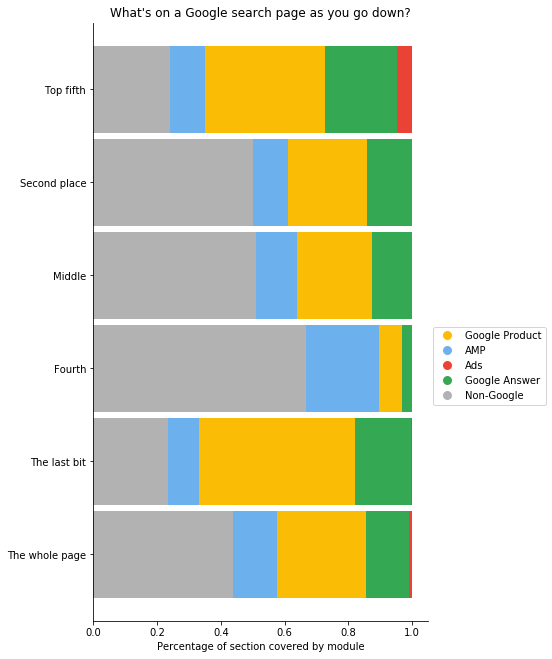

In [38]:
viz = quantiles.loc[:,quantiles.columns.get_level_values(0) == 'area']
viz.index = new_index
ax = viz[::-1].plot(
    kind='barh', 
    stacked=True,
    legend=False,
    figsize=(6, 11),
    width=.93,
    color = [cat2color.get(c) for c in labels],
    title="What's on a Google search page as you go down?"
)

ax.set_xlabel("Percentage of section covered by module")
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# ax.xaxis.set_visible(False)
ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.5))

## Histogram of Google-occupied pixels

\begin{equation}
X_{o} = \frac{o}{o + g + amp + ad}
\end{equation}

\begin{equation}
X_{o} = \frac{tsl}{o + g + amp + ad}
\end{equation}

Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{o}$: is the percentage of real estate that occupy non-Google elements.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the total sum of variable real estate pixels occupied by Google links and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $o$: is the total sum of variable real estate pixels occupied by Organic links.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the total sum of variable real estate pixels occupied by ads.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the total sum of variable real estate pixels occupied by AMP.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $tsl$: is the total sum of variable real estate pixels occupied by traditional organic, amp and YouTube search listings.<br>

In [125]:
blue_link_categories = [
    'organic-search_result',
    'amp-search_result',
    'link-youtube_search_result'
]

In [56]:
pixels = {c : list() for c in area_cols}
for search, df_ in tqdm(df.groupby('fn_input')):
    for col in area_cols:
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[df_.label == 'organic'][col].sum()
        o_sr =  df_[
            df_.category_standard.isin(blue_link_categories)
        ][col].sum()
        g = df_[(df_.label == 'link') | 
                (df_.label == 'answer')][col].sum()
        amp = df_[df_.label == 'amp'][col].sum()

        e1 =  o / (g + ad + o + amp)
        e2 = o_sr / (g + ad + o + amp)

        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'amp' : amp,
            'e1' : e1,
            'e2' : e2,
        }

        pixels[col].append(row)
    
df_pixels = pd.DataFrame(pixels['q1_area'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

100%|██████████| 15281/15281 [04:00<00:00, 63.54it/s]


In [57]:
df_pixels = pd.DataFrame(pixels['q1_area'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

In [58]:
df_pixels.e1.fillna(0, inplace=True)
df_pixels.e2.fillna(0, inplace=True)

In [59]:
fn_pixels = '../data/intermediary/pixels_above_the_fold.csv'
fn_pixels_page = '../data/intermediary/pixels_page.csv'

In [60]:
df_pixels.to_csv(fn_pixels, index=False)
df_pixels_fp.to_csv(fn_pixels_page, index=False)

In [48]:
# df_pixels[
#     (df_pixels.ad > 1) &
#     (df_pixels.o > 1) &
#     (df_pixels.g > 1) &
#     (df_pixels.amp > 1)
# ].search_term.head(20).tolist()

In [61]:
def hist(series, color='black', 
         title=None, 
         fn_out=None,
         left_right_annotations = (None, None)):
    ax = series.plot(kind='hist', 
                           figsize=(10,6),
                           bins=10, 
                           rwidth=.95,
                           color=color,
                           alpha=.9,
                           title=title)

    ax.tick_params(axis="both", which="both", bottom="off", 
                   top="off", labelbottom="on", left="off", 
                   right="off", labelleft="on")

    plt.annotate(left_right_annotations[0], 
                 (0.04, 0), (0, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')
    plt.annotate(left_right_annotations[-1], 
                 (.75, 0), (.75, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')

    ax.set_ylabel("Count of search pages")

    ax.set_axisbelow(True)
    plt.gca().yaxis.grid(True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if fn_out:
         plt.savefig(fn_out)
    
    return ax

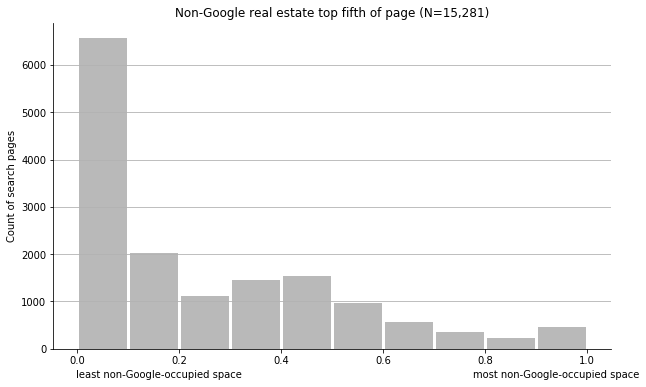

In [80]:
hist(df_pixels.e1,
     left_right_annotations = ('least non-Google-occupied space',
                               'most non-Google-occupied space'),
     color=cat2color['organic'],
     title = f'Non-Google real estate top fifth of page (N={len(df_pixels):,})',
     fn_out='../data/output/figures/eq1_abv.png');

In [66]:
# What percentage of pages have 10% or less of the page occupied by Google?
len(df_pixels[df_pixels.e1 <= .1]) / len(df_pixels) * 100

42.96184804659381

In [67]:
# what percentage of pages have no organic?
len(df_pixels[df_pixels.e1 == 0]) / len(df_pixels) * 100

10.16949152542373

In [68]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.240937778447796, 0.1413100230593995)

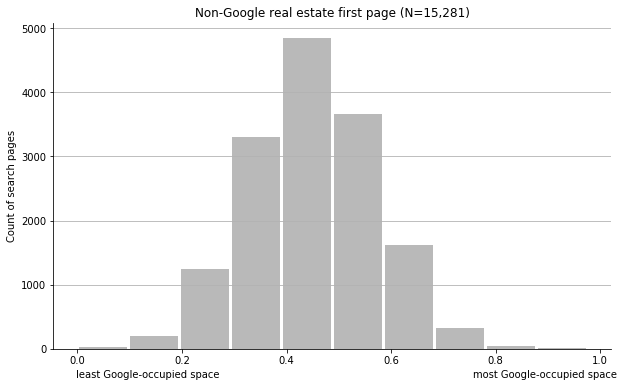

In [79]:
hist(df_pixels_fp.e1,
     title=f'Non-Google real estate first page (N={len(df_pixels):,})',
     left_right_annotations = ('least Google-occupied space',
                               'most Google-occupied space'),
     color=cat2color['organic'],
     fn_out='../data/output/figures/eq1_page.png');

In [76]:
# What percentage of pages have 50% or more of the page occupied by Google?
len(df_pixels_fp[df_pixels_fp.e1 >= .5]) / len(df_pixels) * 100

33.4598521039199

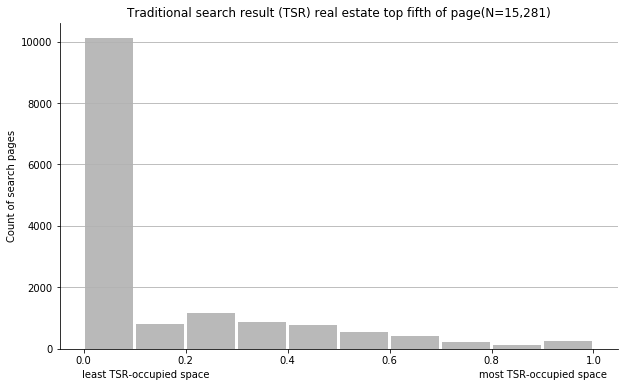

In [81]:
hist(df_pixels.e2,
     color=cat2color['organic'],
     title = f'Traditional search result (TSR) real estate top fifth of page(N={len(df_pixels):,})',
     left_right_annotations=('least TSR-occupied space',
                             'most TSR-occupied space'),
     fn_out='../data/output/figures/eq2_above.png')

In [82]:
# What percentage of pages have 95% or more of the page occupied by self-dealing?
len(df_pixels[df_pixels.e2 <= .1]) / len(df_pixels) * 100

66.15404750997972

In [83]:
len(df_pixels[df_pixels.e2 <= .1])

10109

In [85]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.240937778447796, 0.1413100230593995)

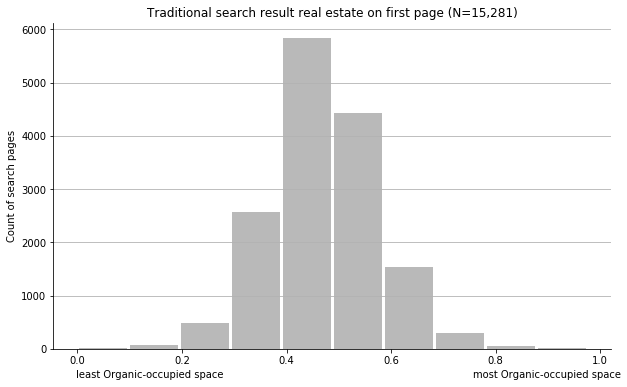

In [87]:
hist(df_pixels_fp.e2,
     color=cat2color['organic'],
     title = f'Traditional search result real estate on first page (N={len(df_pixels_fp):,})',
     left_right_annotations=('least Organic-occupied space',
                             'most Organic-occupied space'),
     fn_out='../data/output/figures/eq2_page.png')

In [88]:
len(df_pixels_fp[df_pixels_fp.e2 >= .5]) / len(df_pixels)

0.3648975852365683

## Computing confidence interval

In [90]:
def SEM(data : pd.DataFrame, 
        confidence : float = 0.95 , 
        scale : int = 100,
        return_tuple = False) -> str:
    """Calculates standard error of the mean."""
    n = len(data)
    m = data.mean()
    std_err = data.sem()
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    s = f"{scale * m:.1f} ± {h * scale :.1f}"
    if return_tuple:
        s = (m, h)
    return s

In [93]:
# index2human = {
#     'e1' : 'R1: g / (o + g)',
#     'e2' : 'R2: (g + ad) / (o + g + ad)',
# }

In [94]:
# results = {}
# for e in [f'e{i}' for i in range(1, 7)]:
#     x_goog = SEM(df_pixels[e])
#     x_goog_fp = SEM(df_pixels_fp[e])
#     results[index2human.get(e)] = {
#         'above the fold' : x_goog + '%',
#         'first page' : x_goog_fp+ '%'
#     }
# ratios = pd.DataFrame(results).T
# ratios.to_csv('../data/output/tables/ratios.csv')
# ratios

No matter what you might consider to be "Google"...
Above the fold is covered with Google properties between 64.6% and 83.2%.
For the first page it is between 40.3% and 54.7%.

# Distance

In [95]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [96]:
df.loc[df['category'] == 'link-youtube', 
       "category_standard"] = 'youtube'
df.loc[df['category'] == 'link-youtube_search_result', 
       "category_standard"] = 'youtube-search-result'

In [99]:
standard_categories = [
    "organic-search_result",
    "organic",
    "ads",
    "amp-card",
    "amp-visual_stories",
    "google-images",
    "youtube",
    "google-maps",
    'google-answer',
    "google-search",
    "google-expandable-answer",
    "amp-search_result",
    "youtube-search-result",
]

In [100]:
df.category_standard.value_counts()

google-search                   287597
google-answer                   126456
organic                         116546
google-misc                     111136
organic-search_result           106693
google-images                   104747
google-expandable-answer        102134
youtube                          78551
google-knowledge-panel-links     58962
amp-card                         56042
amp-search_result                24523
ads                               4568
google-maps                       1966
youtube-search-result             1630
google-video                      1090
amp-visual_stories                 885
Name: category_standard, dtype: int64

In [101]:
header = 160

In [102]:
dist = {k : [] for k in standard_categories}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    for cat in standard_categories:
        __df = _df[_df.category_standard == cat]
        if not __df.empty:
            # standardized
            y_min = ((__df.y_dist.min() - header) 
                / (__df['position_last_element'].iloc[0] - header))
            dist[cat].append(y_min)

100%|██████████| 15281/15281 [01:43<00:00, 147.79it/s]


In [103]:
for k, v in dist.items():
    print(k)
    print(len([_ for _ in v if _]))

organic-search_result
15271
organic
14511
ads
1454
amp-card
9315
amp-visual_stories
842
google-images
12714
youtube
9067
google-maps
1468
google-answer
14346
google-search
15276
google-expandable-answer
13624
amp-search_result
10018
youtube-search-result
1400


In [104]:
for k, v in dist.items():
    fn_out = f'../data/intermediary/{k}_category_distance_raw.csv'
    pd.DataFrame({'dist_y' : v, 'category' : k}).to_csv(fn_out, index=False)

In [105]:
data = []
for cat, v in dist.items():
    dato = pd.DataFrame({'dist_y' : v}).dist_y
    mean = dato.mean()
    median = dato.median()
    err = dato.sem()
    std = dato.std()
    data.append({
        'category' : cat,
        'dist' : mean,
        'dist_median' : median,
        'min' : dato.describe()['min'],
        '25' : dato.describe()['25%'],
        '50' : dato.describe()['50%'],
        '75' : dato.describe()['75%'],
        'max' : dato.describe()['max'],
        'std' : std,
        'sem_error' : err,
        'n' : len(v)
    })
df_dist = pd.DataFrame(data)
del data

In [113]:
df_dist = df_dist[df_dist['category'] != 'organic]'].sort_values(by='dist')#.to_csv('are_these_outliers.csv', index=False)

In [ ]:
# data = []
# for cat, v in dist.items():
#     print(cat)
#     dato = pd.DataFrame({'dist_y' : v}).dist_y.clip(0, 6000)
#     dato.plot(kind='hist', bins=50, xlim=(0, 6000))
#     plt.show();

organic-search_result


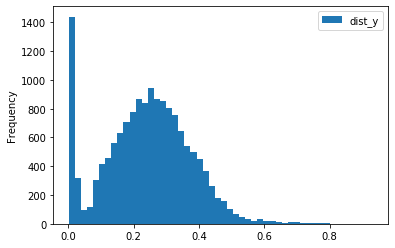

organic


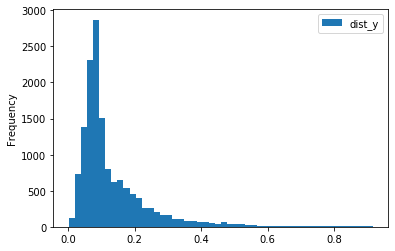

ads


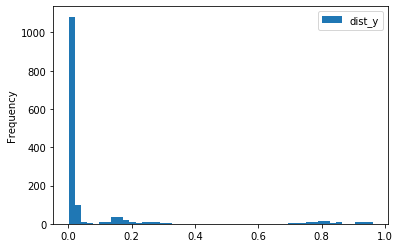

amp-card


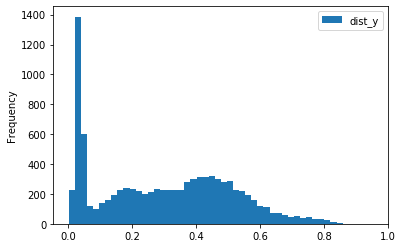

amp-visual_stories


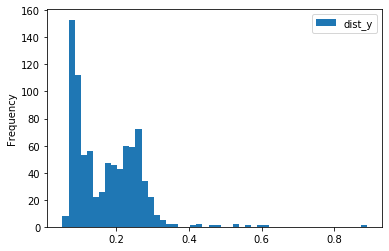

google-images


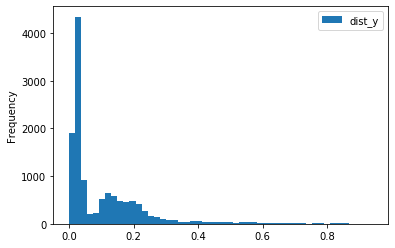

youtube


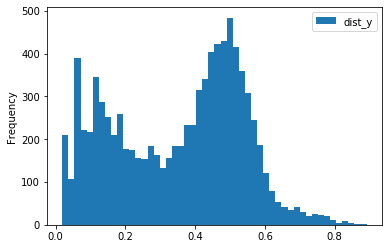

google-maps


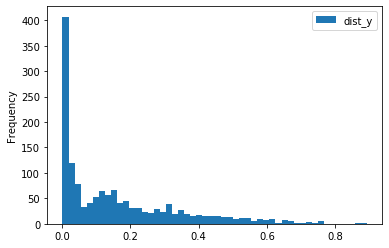

google-answer


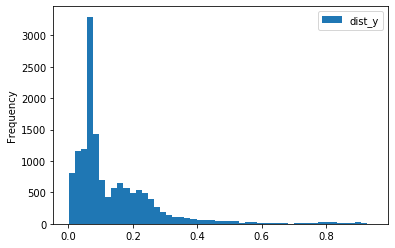

google-search


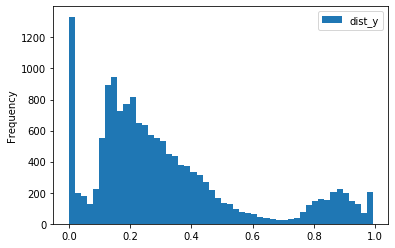

google-expandable-answer


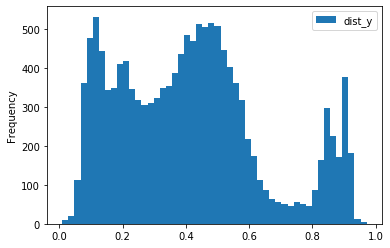

amp-search_result


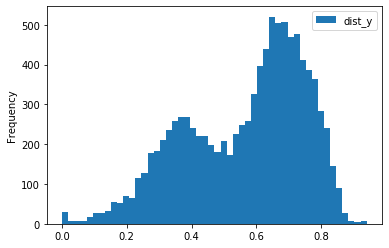

youtube-search-result


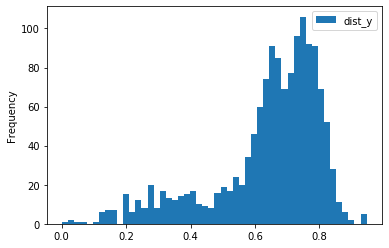

In [107]:
data = []
for cat, v in dist.items():
    print(cat)
    dato = pd.DataFrame({'dist_y' : v})
    dato.plot(kind='hist', bins=50)
    plt.show();

In [108]:
distro = pd.DataFrame()
for cat, v in dist.items():
    print(cat)
    dato = pd.DataFrame({'dist_y' : v, 'category' : cat})
    distro = distro.append(dato, sort=False)

organic-search_result
organic
ads
amp-card
amp-visual_stories
google-images
youtube
google-maps
google-answer
google-search
google-expandable-answer
amp-search_result
youtube-search-result


In [111]:
# ax = distro.boxplot(column=['dist_y'], 
#                   by='category',
#                   rot=90,
#                   figsize=(6, 12),
#                   )

# plt.gca().invert_yaxis()

In [ ]:
# ax = distro.plot(kind='scatter',
#                  y='dist_y', 
#                  x='category',
#                  rot=90,
#                  s=3,
#                  color='black',
#                  alpha=.005,
#                  figsize=(6, 12))
# plt.gca().invert_yaxis()

In [112]:
df_dist

,category,dist,dist_median,min,25,50,75,max,std,sem_error,n
2,ads,0.082753,0.001436,0.000720,0.001210,0.001436,0.021300,0.962086,0.214956,0.005637,1454
5,google-images,0.104948,0.035711,-0.002661,0.024625,0.035711,0.154953,0.942658,0.132630,0.001176,12714
1,organic,0.135439,0.091375,0.001093,0.067814,0.091375,0.162975,0.917805,0.120409,0.001000,14511
8,google-answer,0.138870,0.083989,0.000947,0.060933,0.083989,0.189030,0.945214,0.136212,0.001137,14346
7,google-maps,0.162010,0.108858,0.001041,0.017204,0.108858,0.261398,0.892525,0.176467,0.004606,1468
4,amp-visual_stories,0.170949,0.163516,0.051620,0.088713,0.163516,0.238050,0.889504,0.087774,0.003025,842
0,organic-search_result,0.239410,0.245286,0.000905,0.153083,0.245286,0.328750,0.932852,0.133759,0.001082,15271
3,amp-card,0.298625,0.301699,0.001880,0.077812,0.301699,0.463468,0.952471,0.208659,0.002162,9315
9,google-search,0.314999,0.244405,-0.000278,0.144622,0.244405,0.403290,0.992985,0.253721,0.002053,15276
6,youtube,0.352812,0.397146,0.018953,0.177677,0.397146,0.499619,0.892185,0.184601,0.001939,9067


In [114]:
label2label = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'ads' : "Ads",
    'amp' : 'AMP',
    'organic' : 'Non-Google'
}

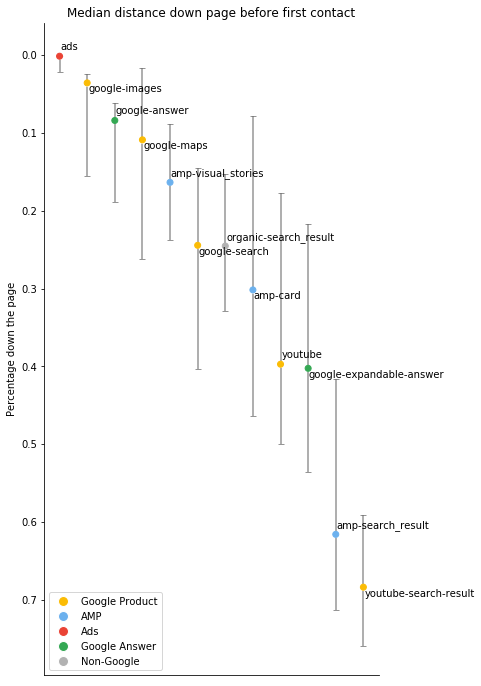

In [115]:
fig, ax = plt.subplots(figsize=(6, 12))
col = 'dist_median'
data = df_dist[df_dist.category != 'organic'].sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]


plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr=[data[col] - data['25'], 
                   data['75']- data[col]], 
             ecolor='dimgrey', color='white',
             capsize = 3,  fmt='o',
             alpha=.7)

plt.gca().invert_yaxis()
# plt.axhline(y=812, color='black', linestyle='--', alpha=.4)
# plt.annotate('Above the fold', (7.3, 800))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
#     txt = f"{row['category']} (N={row['n']:,})"
    txt = row['category']
    if i % 2 == 0:
        y = row[col] -.008
    else:
         y = row[col] +.012
    x = (1 * i)  + .03
    plt.annotate(txt, (x, y), zorder=200)

# for i, (_, row) in enumerate(data.iterrows()):
# #     txt = f"{row['category']} (N={row['n']:,})"
#     txt = row['category']
#     y = row[col] - 2
#     x = (1 * i) + .15
#     if txt == 'google-expandable_answer':
#         x = (1 * i) - 2
#     plt.annotate(txt, (x, y), zorder=200)

ax.set_ylabel("Percentage down the page")
plt.title('Median distance down page before first contact')
ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_visible(False)
ax.legend(handles=legend_elements, loc='lower left')
plt.savefig('../data/output/figures/distance_normalized.png')
del data;

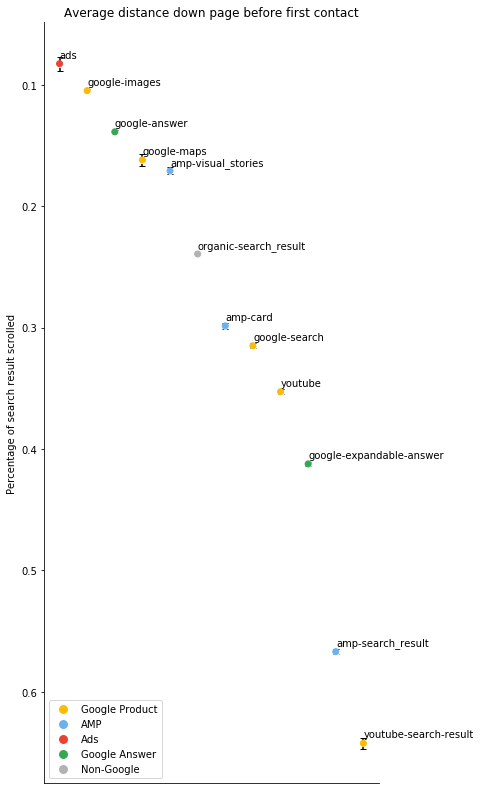

In [116]:
fig, ax = plt.subplots(figsize=(6, 14))
col = 'dist'
data = df_dist[df_dist.category != 'organic'].sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]

legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2label.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()]

plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr='sem_error', 
             ecolor='black', color='white',
             capsize = 3,  fmt='o')

plt.gca().invert_yaxis()
# plt.axhline(y=812, color='black', linestyle='--', alpha=.4)
# plt.annotate('Above the fold', (7.3, 800))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
#     txt = f"{row['category']} (N={row['n']:,})"
    txt = row['category']
    y = row[col] -.005
    x = (1 * i)  + .005
    plt.annotate(txt, (x, y), zorder=200)

# for i, (_, row) in enumerate(data.iterrows()):
# #     txt = f"{row['category']} (N={row['n']:,})"
#     txt = row['category']
#     y = row[col] - 2
#     x = (1 * i) + .15
#     if txt == 'google-expandable_answer':
#         x = (1 * i) - 2
#     plt.annotate(txt, (x, y), zorder=200)

ax.set_ylabel("Percentage of search result scrolled")
plt.title('Average distance down page before first contact')
ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_visible(False)
ax.legend(handles=legend_elements, loc='lower left')
plt.savefig('../data/output/figures/distance.png')
del data;

## How many Blue Links are in a page?

In [126]:
blue_links = []
for search, _df in df[df.area_page != 0].groupby('fn_input'):
    n_blue = len(_df[_df['category_standard'].isin(blue_link_categories)])

    blue_links.append({
        'fn_input' : search,
        'n_blue_links' : n_blue
        
    })
df_bl = pd.DataFrame(blue_links)

In [127]:
df_bl.n_blue_links.mean()

8.586872586872587

In [128]:
df_bl.n_blue_links.sem()

0.011126238643624343

In [129]:
df_bl.describe()

,n_blue_links
count,15281.000000
mean,8.586873
std,1.375385
min,0.000000
25%,8.000000
50%,9.000000
75%,10.000000
max,12.000000


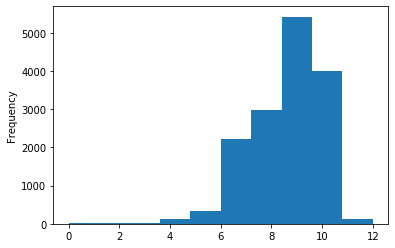

In [130]:
df_bl.n_blue_links.plot(kind='hist', bins=10)

In [131]:
df_bl[df_bl.n_blue_links == 0].fn_input.tolist()

['../data/input/google_search/iPhone-X/2019/11/14/Yujin-Robot-iClebo-Alpha-YCRM0590/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/11/17/California-Golden-Bears/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/11/17/Sri-Lanka/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/11/20/Copa-Libertadores/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/11/29/Protonpump-inhibitor/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/07/Bath-Body-Works/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/09/Google-Sheets/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/13/Livia-Giuggioli/html/webpage_raw.html']

# AMP
How many sites are using AMP compared to how many sites we have?

In [152]:
from urlexpander import get_domain

domains_amp = (df[df.label == 'amp']
                    .link.apply(get_domain)
                    .value_counts())

In [153]:
domains_amp.head(10)

yahoo.com          3235
usatoday.com       1872
people.com         1505
cnbc.com           1458
cbssports.com      1370
nytimes.com        1295
foxnews.com        1231
theguardian.com    1228
espn.com           1200
cnn.com            1149
Name: link, dtype: int64

In [142]:
domains_og = df[df.label == 'organic'].domain.unique()

In [157]:
n_domains_amp = len(domains_amp)
n_domains = len(set(domains_amp.index) | set(domains_og))
n_domains_amp, n_domains

(3114, 25829)

In [158]:
n_domains_amp / n_domains

0.1205621588137365

In [138]:
(df[(df.label == 'amp') &
    (df.q1_area != 0)]
    .link.apply(get_domain)
    .value_counts()
    .head(10))

google.com         509
yahoo.com          493
usatoday.com       285
people.com         266
cbssports.com      230
espn.com           230
foxnews.com        227
cnn.com            181
nypost.com         134
theguardian.com    132
Name: link, dtype: int64